 ## Import Libraries

In [84]:
import pandas as pd
import numpy as np
import os
import pickle
from io import StringIO  
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score
import time

## Load Preprocessed Datasets

In [3]:
path = "../data/preprocessed/"
files = os.listdir(path)

# This would print all the files and directories
for file in files:
    if file.endswith(".csv"):# Checking wheter file ends with .csv
        exec(f"{file[:-4]} = pd.read_csv('{path}'+'{file}')")

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
X_train_scaled.head()

(12754, 8)
(2000, 8)
(12754, 1)
(2000, 1)
(12754, 8)
(2000, 8)


,CreditScore,Age,Balance,NumOfProducts,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male
0,0.811921,-1.080409,-1.331447,2,1,0,0,1
1,-0.435155,-0.190769,-1.331447,3,0,0,0,0
2,1.451447,-0.586164,-1.331447,2,0,0,1,1
3,0.492158,-0.091920,-1.331447,2,0,0,0,1
4,0.609404,-0.783862,1.024451,2,0,0,0,1


In [5]:
# Change shape of y_train and y_test to make it (n_samples,)
y_train=y_train.values.ravel()
y_test=y_test.values.ravel()

## Create necessary variables and additional functions

In [13]:
# Dictionary to save results
results_compare={}
results_compare_test={}
random_state=42

In [8]:
def model_training(X,y, model, m_name):
    
    metrics={}
    start=time.time()
    model.fit(X,y)
    fit_time=time.time()-start
    y_model=model.predict(X)
    y_proba=model.predict_proba(X)[:,1]
    metrics["time_to_fit"]=fit_time
    metrics["accuracy"]=round(accuracy_score(y,y_model),2)
    metrics["recall"]=round(recall_score(y,y_model, pos_label = 1),2)
    metrics["f1"]=round(f1_score(y,y_model, average='binary'), 2)
    results_compare[m_name]=metrics
    return y_model, y_proba
    

In [20]:
def model_predict(X,y, model, m_name):
    metrics={}
    y_pred=model.predict(X)
    y_proba=model.predict_proba(X)[:,1]
    metrics["accuracy_test"]=round(accuracy_score(y,y_pred),2)
    metrics["recall_test"]=round(recall_score(y,y_pred, pos_label = 1),2)
    metrics["f1_test"]=round(f1_score(y,y_pred, average='binary'), 2)
    results_compare_test[m_name]=metrics
    return y_pred, y_proba

In [26]:
# Learning curve plot
def learncurve_plot(X, y, model):
    fractions = np.linspace(0.1, 1.0, 5)
    train_size, train_scores, test_scores = learning_curve(model, X, y, train_sizes=fractions, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.fill_between(train_size,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='blue') 
    ax.fill_between(train_size,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='green')
    ax.plot(train_size,
            train_scores_mean,
            color='blue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_size,
            test_scores_mean,
            color='green',
            marker='o',
            linestyle='-',
            label='CV Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best', fontsize=11);


# Modeling

In this section we use different classification algorythms for churn modeling:
1. Decision Tree will be used as baseline model to understand how it can fit our train data and to see feature importance.
2. Grid Search CV algorythm will be applied to find out hyperparameters for next models:
- Logistic Regression
- Random Forest
- Support Vector Machine classification
- KNN
3. All best estimators for these models will be fit to whole training set. Altogether with preforming learning curve algorythm to understand how model perform with different data volumes.
4. Apply fitted models to test set and analyse performance.

Taking into account that that initial data set was unbalaced and we are trying to predict churn that is minority class, so our main metrics for model performance will be `F1`, `Recall`, `Accuracy`.

## Decision Tree model

In [64]:
dt_model=tree.DecisionTreeClassifier(criterion="gini", random_state=random_state, max_depth=3)
y_dt, dt_train_probs=model_training(X_train,y_train, dt_model, 'DT')
y_pred_dt, dt_probs=model_predict(X_test, y_test, dt_model, 'DT')

In [65]:
print('Decision Tree training results', results_compare['DT'] )

Decision Tree training results {'time_to_fit': 0.4221649169921875, 'accuracy': 0.76, 'recall': 0.85, 'f1': 0.78}


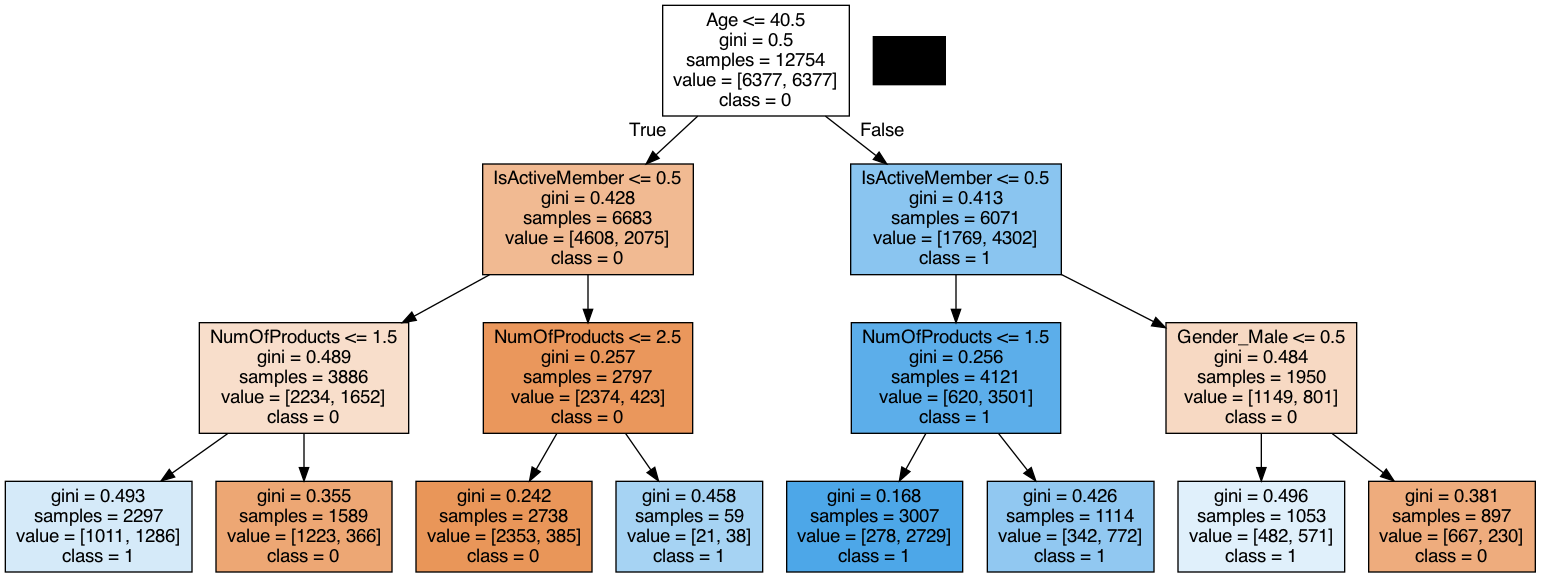

In [23]:
# Visualize the tree
dot_data = StringIO()

tree.export_graphviz(dt_model, out_file=dot_data, 
                                feature_names=list(X_train.columns),  
                                class_names=[str(x) for x in dt_model.classes_],
                                filled=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [24]:
feature_importances = pd.Series(data=dt_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)

Age                  0.469181
IsActiveMember       0.350650
NumOfProducts        0.143341
Gender_Male          0.036828
CreditScore          0.000000
Balance              0.000000
Geography_Germany    0.000000
Geography_Spain      0.000000
dtype: float64


As we see from Decision Tree modeling only 4 features influence users decision whether to stay or to leave the bank programs.

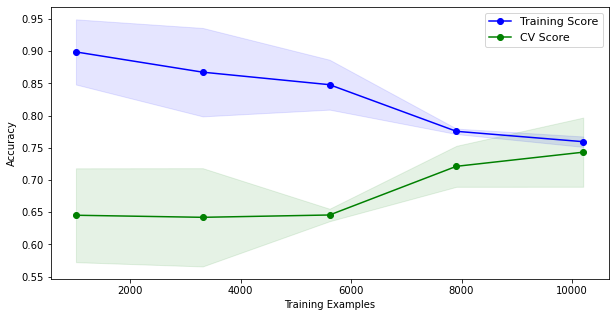

In [27]:
learncurve_plot(X_train, y_train, dt_model)

## Grid search Logistic Regression

Best parameters for Logistic Regression {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


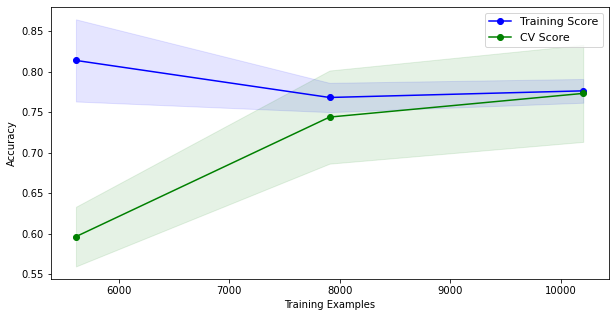

In [67]:
lr = LogisticRegression(random_state=random_state)

grid_param = {
    'max_iter': [100, 250, 500],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(estimator=lr,
                      param_grid=grid_param,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)
best_lr=lr_grid.fit(X_train_scaled,y_train)
y_lr, lr_train_probs=model_training(X_train_scaled, y_train, best_lr.best_estimator_, 'LR')
learncurve_plot(X_train_scaled, y_train, lr_grid.best_estimator_)
print('Best parameters for Logistic Regression', best_lr.best_params_)

In [73]:
print('Logistic Regression best F1 score:', round(best_lr.best_score_,2))

Logistic Regression best F1 score: 0.77


## Grid search Random Forest

{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


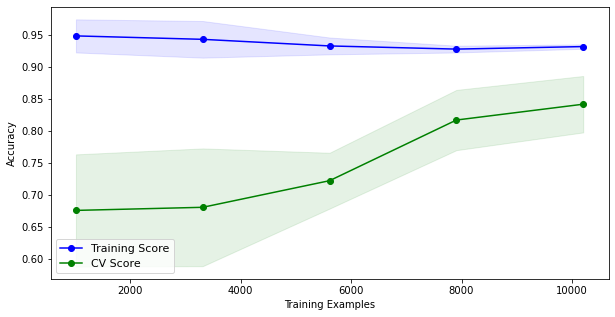

In [59]:
rf = RandomForestClassifier(random_state=random_state)

grid_param = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7, 10, 15],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [2, 3, 5],
            'min_samples_split': [2, 3, 5]
}

rf_grid = GridSearchCV(estimator=rf,
                      param_grid=grid_param,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)
best_rf=rf_grid.fit(X_train_scaled,y_train)
y_rf, rf_train_probs=model_training(X_train_scaled,y_train, best_rf.best_estimator_, 'RF')
learncurve_plot(X_train_scaled, y_train, best_rf.best_estimator_)
print('Best parameters for Random Forest',best_rf.best_params_)

In [71]:
print('Random Forest best F1 score:', round(best_rf.best_score_,2))

Random Forest best F1 score: 0.84


## Grid search SVM

In [79]:
svm = SVC(random_state=random_state, probability=True, class_weight='balanced')

grid_param = [{'kernel': ['rbf'],
                'gamma': [0.1, 0.01],
                'C': [.1, 1, 2]},
              {'kernel': ['poly'],
               'degree': [2, 3],
               'gamma': [0.1, 0.01],
               'C': [.1, 1, 2]}]

svm_grid = GridSearchCV(estimator=svm,
                      param_grid=grid_param,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)
best_svm=svm_grid.fit(X_train_scaled,y_train)


{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}


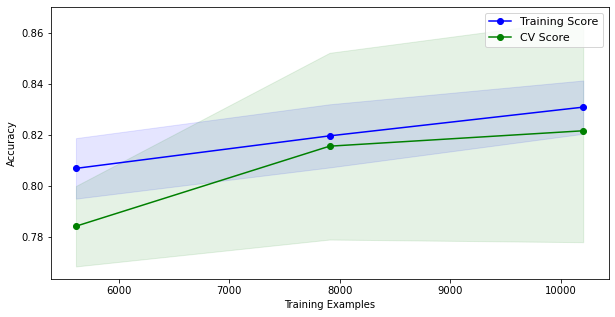

In [81]:
y_svm, svm_train_probs=model_training(X_train_scaled,y_train, best_svm.best_estimator_, 'SVM')
learncurve_plot(X_train_scaled, y_train, best_svm.best_estimator_)
print(best_svm.best_params_)

In [82]:
print('SVM best F1 score:', round(best_svm.best_score_,2))

SVM best F1 score: 0.82


## Grid search KNN

{'n_neighbors': 9}


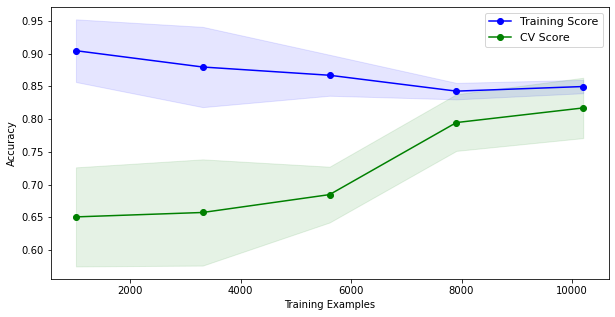

In [56]:
knn = KNeighborsClassifier()

grid_param = {
             'n_neighbors':[1,3,5,7,9,12,15,20]
             }

knn_grid = GridSearchCV(estimator=knn,
                      param_grid=grid_param,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)
best_knn=knn_grid.fit(X_train_scaled,y_train)
y_knn, knn_train_probs=model_training(X_train_scaled,y_train, best_knn.best_estimator_, 'KNN')
learncurve_plot(X_train_scaled, y_train, best_knn.best_estimator_)
print(best_knn.best_params_)

In [74]:
print('KNN best F1 score:', round(best_knn.best_score_,2))

KNN best F1 score: 0.81


## Compare results

In [83]:
pd.DataFrame(results_compare).T

,time_to_fit,accuracy,recall,f1
DT,0.422165,0.76,0.85,0.78
LR,0.073257,0.78,0.78,0.78
RF,0.602746,0.93,0.93,0.93
SVM,61.517289,0.83,0.82,0.83
KNN,0.019821,0.85,0.86,0.85


Let's plot ROC-AUC curve to understand models performance. ROC-AUC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the score, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [47]:
roc_dt=roc_auc_score(y_train, y_dt)
false_dt, true_dt, _ =roc_curve(y_train, dt_train_probs)

roc_rf=roc_auc_score(y_train, y_rf)
false_rf, true_rf, _ =roc_curve(y_train, rf_train_probs)

roc_lr=roc_auc_score(y_train, y_lr)
false_lr, true_lr, _ =roc_curve(y_train, lr_train_probs)

roc_svm=roc_auc_score(y_train, y_svm)
false_svm, true_svm, _ =roc_curve(y_train, svm_train_probs)

roc_knn=roc_auc_score(y_train, y_knn)
false_knn, true_knn, _ =roc_curve(y_train, knn_train_probs)

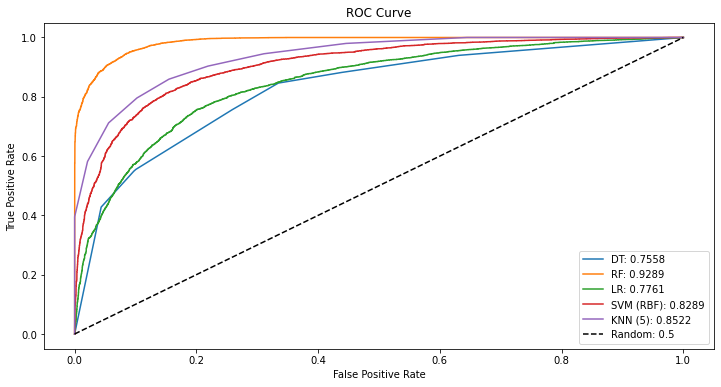

In [49]:
#Built the plot for all these ROC curves

plt.figure(figsize = (12,6), linewidth = 2)

plt.plot(false_dt, true_dt, label = 'DT: ' + str(round(roc_dt, 4)))
plt.plot(false_rf, true_rf, label = 'RF: ' + str(round(roc_rf, 4)))
plt.plot(false_lr, true_lr, label = 'LR: ' + str(round(roc_lr, 4)))
plt.plot(false_svm, true_svm, label = 'SVM (RBF): ' + str(round(roc_svm, 4)))
plt.plot(false_knn, true_knn, label = 'KNN (5): ' + str(round(roc_knn, 4)))

plt.plot([0, 1], [0, 1], 'k--', label = 'Random: 0.5')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

plt.show()

Among all models Random Forest provided better results by all significant metrics. We will need to check this model result on predicting for unseen data from Test set.

## Predict on Test set

In [50]:
y_dt_pred, dt_probs=model_predict(X_test, y_test, dt_model, 'DT')
y_lr_pred, lr_probs=model_predict(X_test_scaled, y_test, best_lr, 'LR')
y_rf_pred, rf_probs=model_predict(X_test_scaled, y_test, best_rf, 'RF')
y_svm_pred, svm_probs=model_predict(X_test_scaled, y_test, best_svm, 'SVM')
y_knn_pred, knn_probs=model_predict(X_test_scaled, y_test, best_knn, 'KNN')

In [77]:
pd.DataFrame(results_compare_test).T

,accuracy_test,recall_test,f1_test
DT,0.68,0.71,0.48
LR,0.72,0.59,0.46
RF,0.81,0.68,0.60
SVM,0.80,0.70,0.60
KNN,0.80,0.69,0.58


In [52]:
roc_dt=roc_auc_score(y_test, y_dt_pred)
false_dt, true_dt, _ =roc_curve(y_test, dt_probs)

roc_rf=roc_auc_score(y_test, y_rf_pred)
false_rf, true_rf, _ =roc_curve(y_test, rf_probs)

roc_lr=roc_auc_score(y_test, y_lr_pred)
false_lr, true_lr, _ =roc_curve(y_test, lr_probs)

roc_svm=roc_auc_score(y_test, y_svm_pred)
false_svm, true_svm, _ =roc_curve(y_test, svm_probs)

roc_knn=roc_auc_score(y_test, y_knn_pred)
false_knn, true_knn, _ =roc_curve(y_test, knn_probs)

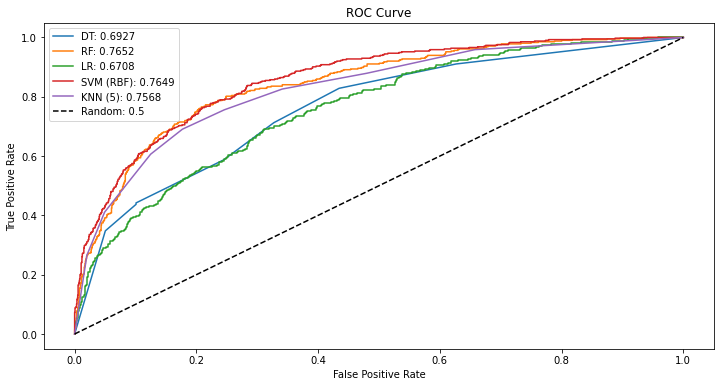

In [53]:
#Built the plot for all these ROC curves

plt.figure(figsize = (12,6), linewidth = 2)

plt.plot(false_dt, true_dt, label = 'DT: ' + str(round(roc_dt, 4)))
plt.plot(false_rf, true_rf, label = 'RF: ' + str(round(roc_rf, 4)))
plt.plot(false_lr, true_lr, label = 'LR: ' + str(round(roc_lr, 4)))
plt.plot(false_svm, true_svm, label = 'SVM (RBF): ' + str(round(roc_svm, 4)))
plt.plot(false_knn, true_knn, label = 'KNN (5): ' + str(round(roc_knn, 4)))

plt.plot([0, 1], [0, 1], 'k--', label = 'Random: 0.5')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

plt.show()

Random Forest classification can predict churn with 80% accuracy and 70% recall. ROC-AUC score for Random Forest is higher than for other algorythms.

### Random Forest model features importance

In [80]:
feature_importances_rf = pd.Series(data=best_rf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances_rf)

Age                  0.291975
CreditScore          0.155148
Balance              0.150987
IsActiveMember       0.133313
NumOfProducts        0.133245
Gender_Male          0.086472
Geography_Spain      0.037353
Geography_Germany    0.011507
dtype: float64


## Summary

5 different classification algorythms were fit to train set and then predicted classes for test set. 
- Random Forest performed better among them with F1 of 0.93 on train set and 0.60 on test set. This significant drop in performance can be related to overfitting on training data.
- Second choice among models is SVM. It has F1 of 0.83 on train set and 0.6 on test. However, it took longer to fit the model to the dataset.


- Feature importance for Decision Tree and Random Forest shown common features - `Age`, `IsActiveMember`, `NumOfProducts`, `Gender_Male`. `CreditScore` and `Balance` are on 2nd and 3rd place for Random Forest classification.

#### Next steps:

- Bank can provide customers probable churn rating system based on important features for our model and then set the threshold when to start customer success team interventions in order to help clients to stay with bank programs.

- Other data related to users can be gathered for further analysis for example:
     - Demographic data, like marital status, education level, number of denpendents, employment status, residence;
     - Account information: type of accounts and products they are using;
     - Transaction history: number of transactions for analysed period with their frequency and amount;
     - Customer interactions: phone, message or visit contacts with bank's representative, their number and some sort of classification;
     - External factors, such as changes in the economy or the customer's personal circumstances, can also influence the likelihood of churn. In our case we had information for 3 different countries but not obvious reasons why users from Germany churn more. Additional data and analysis may help to identify the cause of this trend.